In [1]:
import numpy as np
import pandas as pd
import surprise
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import matplotlib.pyplot as plot
import seaborn as sn

# Business Problem
Problem statement.

Build a recommender system by using cosine simillarties score.


# Data Collection

In [2]:
b = pd.read_csv("C://Users//Dell//Downloads//book.csv",encoding='latin1')
b

,Unnamed: 0,User.ID,Book.Title,Book.Rating
0,1,276726,Classical Mythology,5
1,2,276729,Clara Callan,3
2,3,276729,Decision in Normandy,6
3,4,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,5,276737,The Mummies of Urumchi,6
...,...,...,...,...
9995,9996,162121,American Fried: Adventures of a Happy Eater.,7
9996,9997,162121,Cannibal In Manhattan,9
9997,9998,162121,How to Flirt: A Practical Guide,7
9998,9999,162121,Twilight,8


In [3]:
b1 = b.iloc[:,1:]

In [4]:
b1.columns = ['userID', 'title', 'bookRating']
b1.head()

,userID,title,bookRating
0,276726,Classical Mythology,5
1,276729,Clara Callan,3
2,276729,Decision in Normandy,6
3,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,276737,The Mummies of Urumchi,6


# EDA and visuvalizations

In [5]:
print('# of records: %d\n# of books: %d\n# of users: %d' % (len(b1), len(b1['title'].unique()), len(b1['userID'].unique())))

# of records: 10000
# of books: 9659
# of users: 2182


In [6]:
palette = sn.color_palette("RdBu", 10)

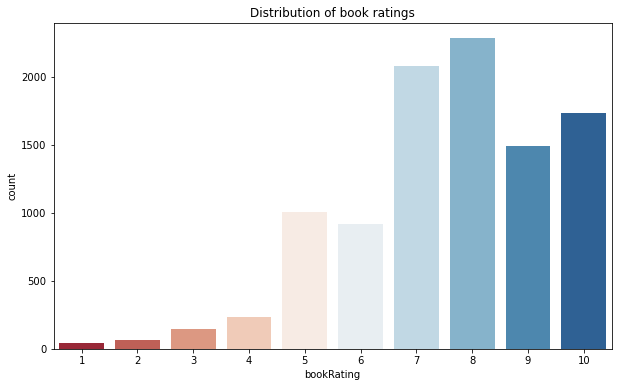

In [7]:
fig, ax = plot.subplots(figsize = (10, 6))
sn.countplot(x = 'bookRating', data = b1, palette = palette)
ax.set_title('Distribution of book ratings')

plot.show()

In [8]:
b1.bookRating.unique()

array([ 5,  3,  6,  8,  7, 10,  9,  4,  1,  2], dtype=int64)

In [9]:
reader = surprise.Reader(rating_scale = (1, 10))

In [10]:
data = surprise.Dataset.load_from_df(b1[['userID', 'title', 'bookRating']], reader)

In [11]:
trainset, testset = train_test_split(data, test_size=.20)

In [12]:
benchmark = []

In [13]:
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), BaselineOnly(), CoClustering()]:
    results = cross_validate(algorithm, data, measures = ['RMSE'], cv=3, verbose = False)
    tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index = ['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [14]:
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,1.679263,4.387444,0.026854
SVD,1.688512,0.457410,0.019547
KNNBaseline,1.704059,0.093840,0.025381
BaselineOnly,1.708322,0.028895,0.019943
SlopeOne,1.817681,0.900005,0.050511
KNNWithMeans,1.820032,0.086069,0.028707
KNNBasic,1.822357,0.067102,0.033700
CoClustering,1.857071,1.108337,0.018680
NMF,1.909471,1.226273,0.020432


# Building Recommendation System using surprice

In [15]:
algo = SVD()

In [16]:
algo.fit(trainset)

In [17]:
predictions = algo.test(testset)

In [18]:
from surprise import accuracy

In [19]:
accuracy.rmse(predictions, verbose=True)

RMSE: 1.6966


1.6965706060215886

In [20]:
def recommendation(userID):
    user = b1.copy()
    already_read = b1[b1['userID'] == userID]['title'].unique()
    user = user.reset_index()
    user = user[~user['title'].isin(already_read)]
    user['Estimate_Score']=user['title'].apply(lambda x: algo.predict(userID, x).est)
    #user = user.drop('title', axis = 1)
    user = user.sort_values('Estimate_Score', ascending=False)
    print(user.head(10))

# Building Recommendation System using correlation

In [21]:
each_book_rating = pd.pivot_table(b1, index='userID', values='bookRating', columns='title', fill_value=0)

In [22]:
corr = np.corrcoef(each_book_rating.T)

In [23]:
corr.shape

(9659, 9659)

In [24]:
book_list=  list(each_book_rating)

In [25]:
book_titles =[] 

In [26]:
for i in range(len(book_list)):
    book_titles.append(book_list[i])

In [27]:
book_titles

[' Jason, Madison &amp',
 ' Other Stories;Merril;1985;McClelland &amp',
 ' Repairing PC Drives &amp',
 "'48",
 "'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities",
 '...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR',
 '01-01-00: A Novel of the Millennium',
 '1,401 More Things That P*Ss Me Off',
 '10 Commandments Of Dating',
 '100 Great Fantasy Short, Short Stories',
 '1001 Brilliant Ways to Checkmate',
 '101 Bright Ideas: Esl Activities for All Ages',
 '101 Dalmatians',
 '101 Essential Tips: House Plants',
 '101 Telephone Jokes',
 '101 Wacky Computer Jokes',
 '101 Ways to Make Money at Home',
 '11 Edward Street',
 '11th Hour',
 '13 99 Euros',
 '14,000 Things to Be Happy About',
 '1984',
 '1st to Die: A Novel',
 '20 Jahre 40 bleiben. Jung und schÃ?Â¶n in den besten Jahren.',
 '20 Years of Censored News',
 '20,000 Leagues Under the Sea (Wordsworth Collection)',
 '20,001 Names for Baby',
 '2001 Spanish and English Idioms/2001 Modismos Espanoles E Ingleses: 

In [28]:
def get_recommendation(books_list):
    book_similarities = np.zeros(corr.shape[0])
    
    for book in books_list:
        book_index = book_titles.index(book)
        book_similarities += corr[book_index] 
        book_preferences = []
    for i in range(len(book_titles)):
        book_preferences.append((book_titles[i],book_similarities[i]))
        
    return sorted(book_preferences, key = lambda x: x[1], reverse = True)

In [29]:
recommendation(276747)

      index  userID                                              title  \
9401   9401  161870                                   One Police Plaza   
5723   5723    2599                                 Martian Chronicles   
277     277  276939                                 Martian Chronicles   
877     877  277478                                           Hannibal   
410     410  277087                                           Hannibal   
4515   4515    1903  Mendoza in Hollywood (A Novel of the Company, ...   
230     230  276928                                        Silent Snow   
6361   6361    3305  Mothering the Mother: How a Doula Can Help You...   
9367   9367  161870  All They Want for Christmas: Comfort and Joy /...   
1147   1147  277740             Frankenstein Or, the Modern Prometheus   

      bookRating  Estimate_Score  
9401          10        8.249010  
5723           9        8.154402  
277            9        8.154402  
877           10        8.125839  
410       

In [30]:
my_fav_books = ['Classical Mythology','Clara Callan']

In [31]:
print('The books you might like: \n' , get_recommendation(my_fav_books)[:10])

The books you might like: 
 [('Clara Callan', 0.9995414947271893), ('Classical Mythology', 0.9995414947271893), ('Decision in Normandy', 0.9995414947271893), ("Silent Witness: How Forensic Anthropology Is Used to Solve the World's Toughest Crimes", -0.0009170105456211816), ('No Witnesses: A Novel', -0.0009170105456211817), ('Roadwork', -0.0009170105456211817), ('J Is for Judgment', -0.000917010545621182), ('A Is for Alibi (Kinsey Millhone Mysteries (Paperback))', -0.0009170105456211822), ('American Way of Sex: An Informal Illustrated History (254p)', -0.0009170105456211827), ('Death of a River Guide', -0.0009170105456211827)]
